Query on Cosmohub to get Gaia EDR3 data:

    SELECT `solution_id`, `designation`, `source_id`, `ra`, `ra_error`, `dec`, `dec_error`, `parallax`, `parallax_error`, `pm`, `pmra`, `pmra_error`, `pmdec`, `pmdec_error`, `ra_dec_corr`, `ra_parallax_corr`, `ra_pmra_corr`, `ra_pmdec_corr`, `dec_parallax_corr`, `dec_pmra_corr`, `dec_pmdec_corr`, `parallax_pmra_corr`, `parallax_pmdec_corr`, `pmra_pmdec_corr`, `visibility_periods_used`, `astrometric_sigma5d_max`, `ruwe`, `duplicated_source`, `phot_g_mean_flux`, `phot_g_mean_flux_error`, `phot_g_mean_flux_over_error`, `phot_g_mean_mag`, `phot_bp_mean_flux`, `phot_bp_mean_flux_error`, `phot_bp_mean_flux_over_error`, `phot_bp_mean_mag`, `phot_rp_mean_flux`, `phot_rp_mean_flux_error`, `phot_rp_mean_flux_over_error`, `phot_rp_mean_mag`, `dr2_radial_velocity`, `dr2_radial_velocity_error`, `l`, `b`, `phot_bp_rp_excess_factor` FROM gaia_edr3 WHERE `phot_g_mean_mag` < 18.5 AND (`b` > 30 OR `b` < -30)
    
    
Validation plots:
- Sky density in bins of magnitude (healpix)
- xy plane density

Parameters:
- $z_\odot$
- orientation of the galactic plane

These cartesian coordinates are a rotation $\mathbf{M}$ away from the ICRS cartesian coordinates
$$
\textbf{x} = (x, y, z) = \mathbf{M}\,\textbf{x}_{\textrm{ICRS}}
$$
where one angle in the rotation matrix is set by the (fixed) sky position of the Galactic center, one is set by the Sun's height above the midplane and distance to the Galactic center, and one is set by the orientation of the Galactic plane (on the sky?) or position angle or "roll" or whatever.

In the rotated "Galactocentric" coordinates $\textbf{x}$:
$$
\rho(\textbf{x}) = \rho_0 \, \left[
    \textrm{sech}^2\left(\frac{z + z_\odot}{2\,h_1}\right) + 
    \alpha \, \textrm{sech}^2\left(\frac{z + z_\odot}{2\,h_2}\right)
    \right]
$$
where the density is assumed to be uniform in $x, y$ and only depend on $z$.

In [1]:
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.optimize import minimize

from pyia import GaiaData

from coord_helpers import gal_to_schmagal, schmagal_to_gal
from model_helpers import (ln_density, ln_normal, ln_two_sech2, ln_uniform,
                           ln_integrand, get_ln_Veff,
                           ln_likelihood)

In [2]:
usys = [u.pc, u.rad, u.Msun, u.Myr]

In [3]:
allg = GaiaData('/mnt/home/apricewhelan/data/GaiaEDR3/Gaia-b30-G18.5.fits')

In [4]:
G_max = 18.5 * u.mag
min_b = 30 * u.deg
max_dist = 1.5 * u.kpc

mask = (
    (allg.parallax > coord.Distance(max_dist).parallax) & 
    ((allg.parallax / allg.parallax_error) > 5)
)
g = allg[mask]

len(g), len(allg)

(17896452, 37766503)

In [5]:
# Raw photometry
# MG = g.phot_g_mean_mag - g.distmod
# BPRP = g.bp_rp

# attempt at extinction-correcting the photometry:
MG = g.get_G0() - g.distmod
BPRP = g.get_BP0() - g.get_RP0()

/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/numpy/lib/polynomial.py:734: RuntimeWarning: overflow encountered in multiply
  y = y * x + p[i]
/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/pyia/extinction.py:33: RuntimeWarning: overflow encountered in multiply
  AG = F1(curbp)*A0
/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/pyia/extinction.py:34: RuntimeWarning: overflow encountered in multiply
  Abp = F2(curbp)*A0
/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/pyia/extinction.py:35: RuntimeWarning: overflow encountered in multiply
  Arp = F3(curbp)*A0
/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/pyia/extinction.py:36: RuntimeWarning: overflow encountered in add
  curbp1 = bp-rp-Abp+Arp
/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/numpy/lib/polynomial.py:734: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


Select the upper main sequence (but not too upper, and remove the giant branch). These $M_G$ limits correspond roughly to F-type stars through mid-K stars based on:
https://www.pas.rochester.edu/~emamajek/EEM_dwarf_UBVIJHK_colors_Teff.txt

In [6]:
MG_lim = [2.5, 6] * u.mag
maxdist = coord.Distance(distmod=G_max - max(MG_lim))
print(f"rough maximum distance for completeness: {maxdist:.0f}")

rough maximum distance for completeness: 3 kpc


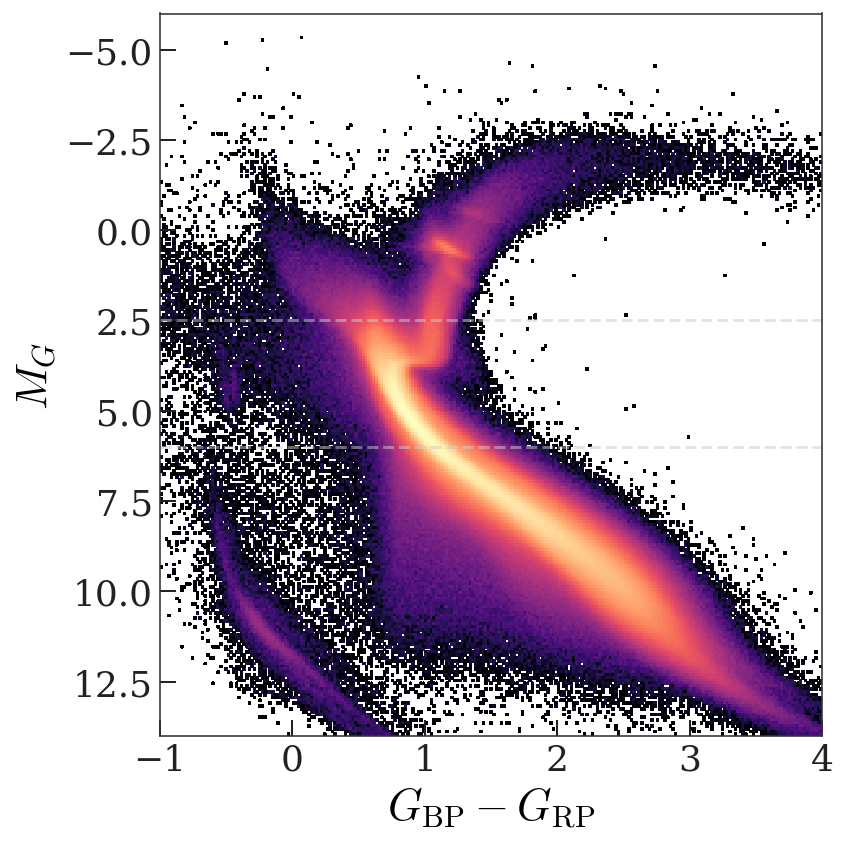

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

bins = (np.linspace(-1, 4, 256),
        np.linspace(-6, 14, 256))

ax.hist2d(
    BPRP.value, 
    MG.value,
    bins=bins,
    norm=mpl.colors.LogNorm()
)

for lim in MG_lim:
    ax.axhline(lim.value, marker='', color='#cccccc', 
               linestyle='--', alpha=0.5)

ax.set_ylim(14, -6)
ax.set_xlabel(r'$G_{\rm BP}-G_{\rm RP}$')
ax.set_ylabel('$M_G$')

fig.tight_layout()

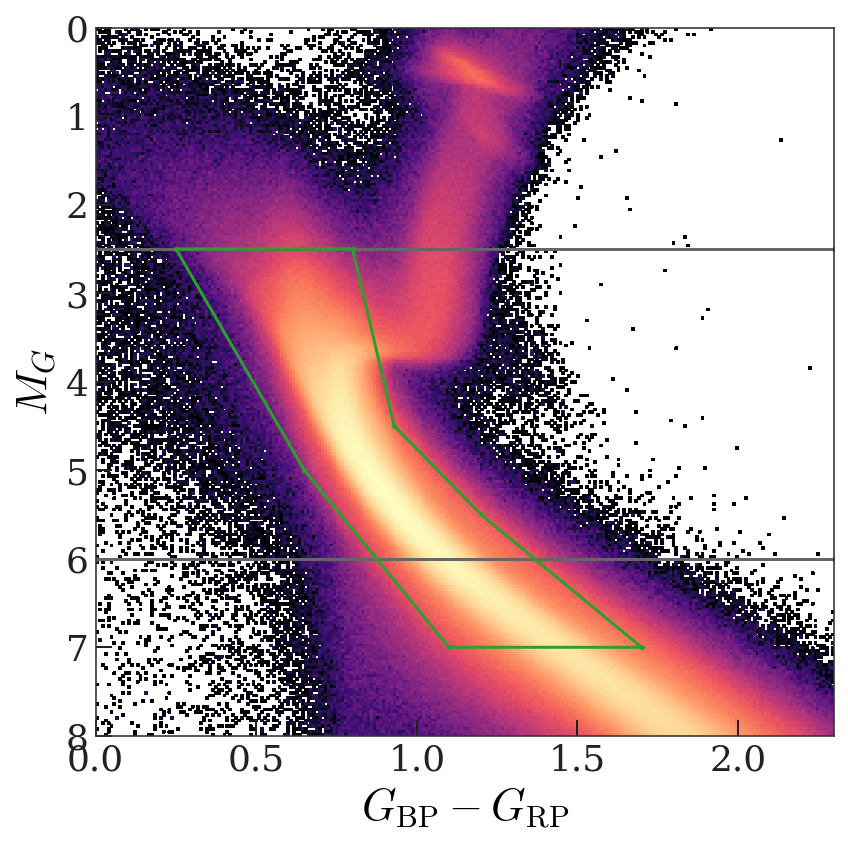

In [8]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.hist2d(
    BPRP.value, 
    MG.value,
    bins=(np.linspace(0, 2.3, 256),
          np.linspace(0, 8, 256)),
    norm=mpl.colors.LogNorm()
)

for lim in MG_lim:
    ax.axhline(lim.value)
    
nodes = np.array([
    [1.7, 7],
    [1.1, 7],
    [0.65, 5],
    [0.25, 2.5],
    [0.8, 2.5],
    [0.93, 4.5],
    [1.2, 5.5],
    [1.7, 7]
])
ax.plot(nodes[:, 0], nodes[:, 1], color='tab:green')
path_ = mpl.path.Path(nodes)
cmd_mask = (
    path_.contains_points(np.stack((BPRP.value, MG.value)).T) &
    (MG > MG_lim[0]) &
    (MG < MG_lim[1])
)

ax.set_ylim(8, 0)
ax.set_xlabel(r'$G_{\rm BP}-G_{\rm RP}$')
ax.set_ylabel('$M_G$')
fig.tight_layout()

In [9]:
mask = (
    cmd_mask
)
cmd_mask.sum(), mask.sum()

(5756835, 5756835)

In [10]:
ms_g = g[mask]
(ms_g.ruwe < 1.4).sum() / len(ms_g)

0.9020932508922003

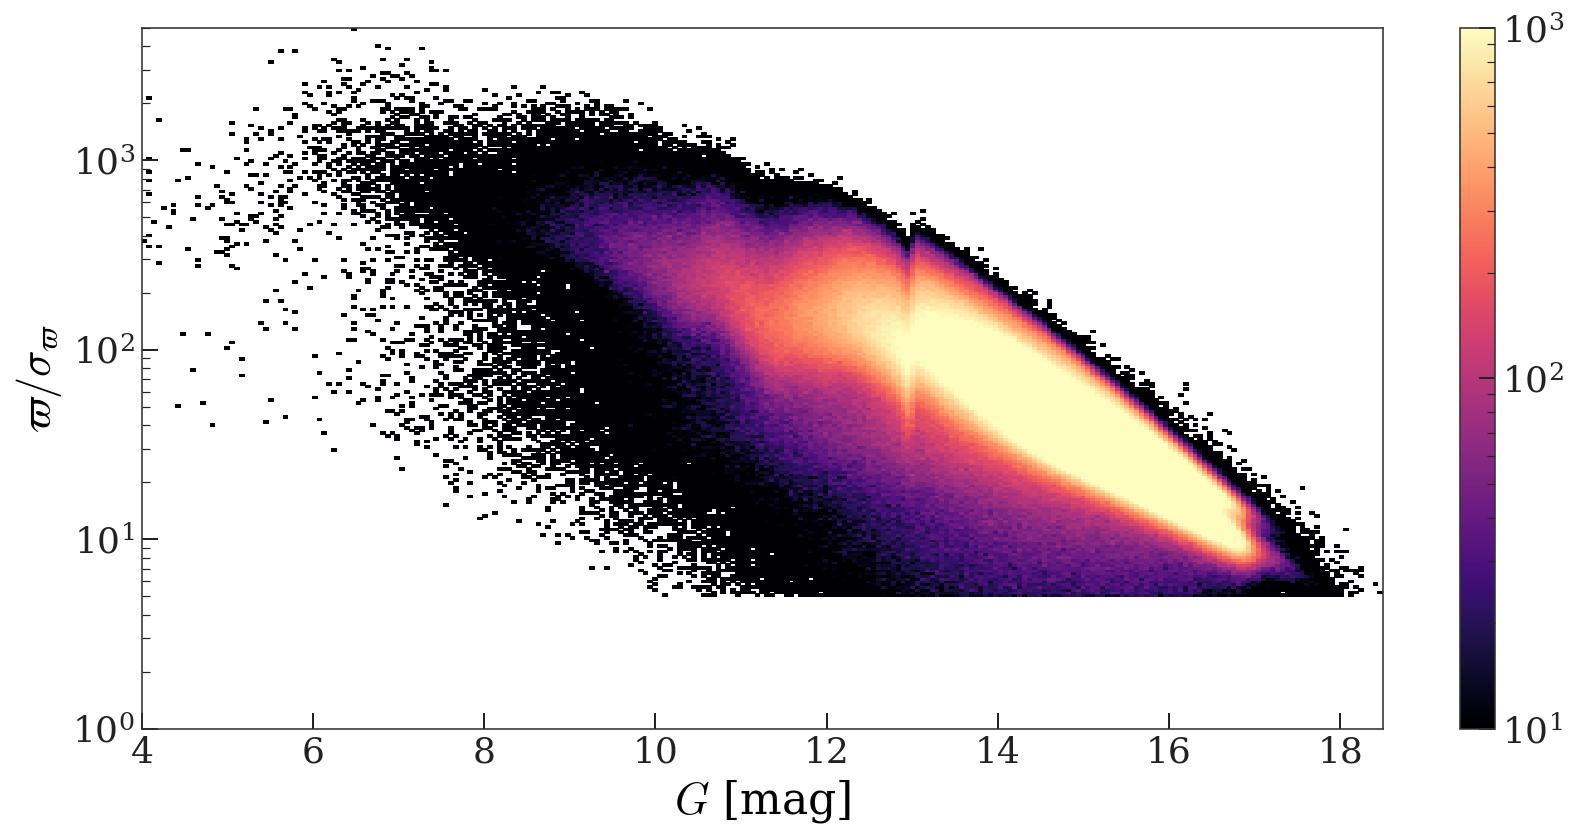

In [11]:
plt.figure(figsize=(12, 6))
plt.hist2d(
    ms_g.phot_g_mean_mag.value, 
    ms_g.parallax.value / ms_g.parallax_error.value,
    bins=(np.linspace(4, 18.5, 256),
          np.geomspace(1, 5e3, 256)),
    norm=mpl.colors.LogNorm(vmin=10, vmax=1e3)
)
plt.colorbar()
plt.yscale('log')
plt.xlabel('$G$ [mag]')
plt.ylabel(r'$\varpi / \sigma_\varpi$')
plt.tight_layout()

In [12]:
gal = ms_g.skycoord.galactic
x, y, z = gal.represent_as('cartesian').xyz.to_value(u.kpc)

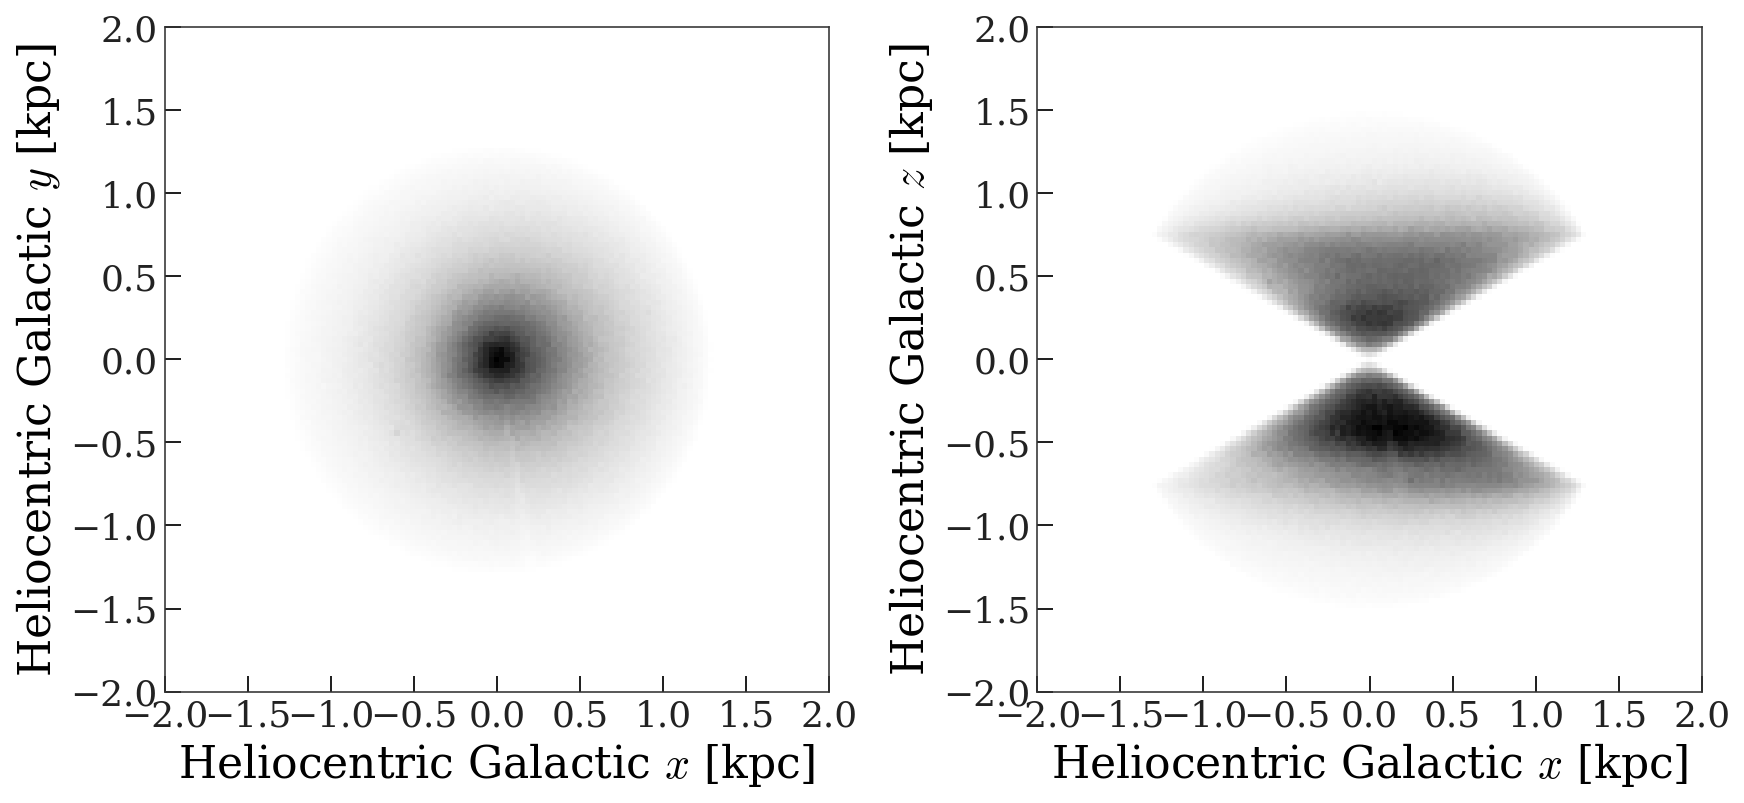

In [13]:
fig, axes = plt.subplots(
    1, 2, 
    figsize=(12, 6), 
    constrained_layout=True
)

lim = (-2, 2)
for ax, coords, labels in zip(axes, 
                              [(x, y), (x, z)], 
                              [('x', 'y'), ('x', 'z')]):
    ax.hist2d(
        coords[0], 
        coords[1], 
        bins=np.linspace(*lim, 128), 
        cmap='Greys'
    #     norm=mpl.colors.LogNorm()
    )

    circ = mpl.patches.Circle(
        (0, 0),
        radius=maxdist.to_value(u.kpc),
        linewidth=2, 
        facecolor='none',
        edgecolor='tab:red'
    )
    ax.add_patch(circ)
    ax.set_aspect('equal')
    
    ax.set(
        xlabel=f'Heliocentric Galactic ${labels[0]}$ [kpc]',
        ylabel=f'Heliocentric Galactic ${labels[1]}$ [kpc]',
        xlim=lim,
        ylim=lim,
        xticks=np.arange(lim[0], lim[1]+0.1, 0.5),
        yticks=np.arange(lim[0], lim[1]+0.1, 0.5)
    );

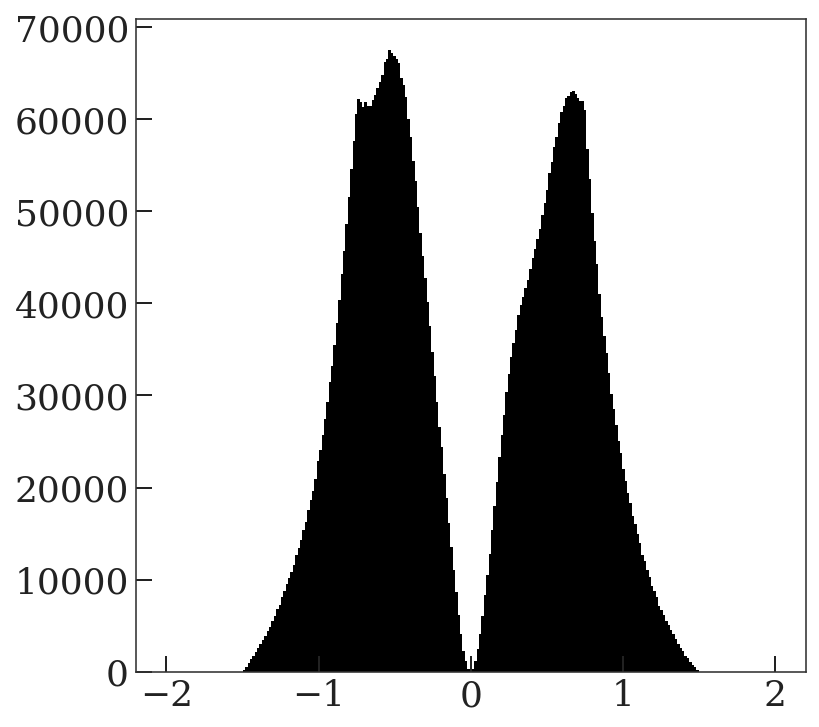

In [14]:
plt.hist(z, bins=np.linspace(-2, 2, 256));
# plt.yscale('log')

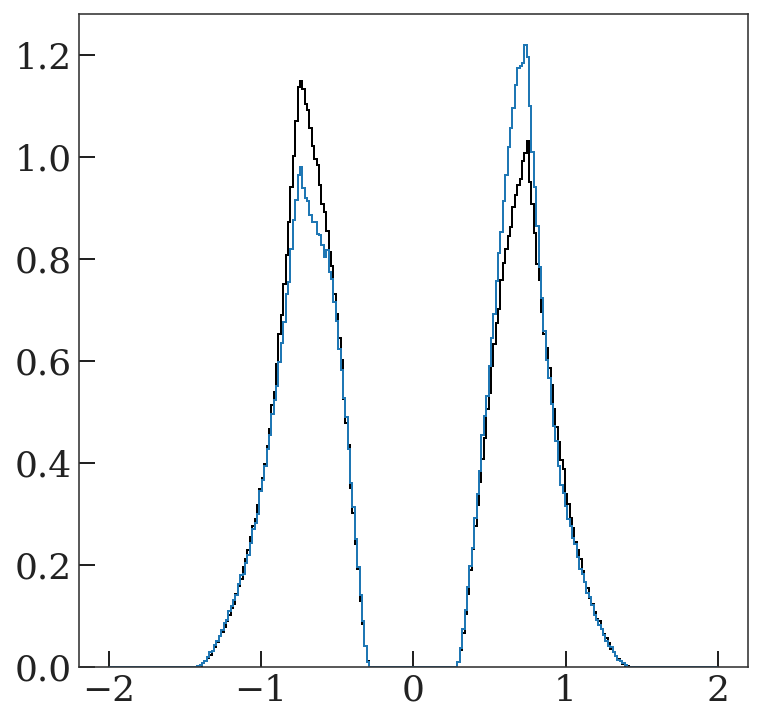

In [15]:
kw = dict(bins=np.linspace(-2, 2, 256), density=True, histtype='step')
plt.hist(z[x > 0.5], **kw)
plt.hist(z[x < -0.5], **kw);
# plt.yscale('log')

In [16]:
_gal = coord.Galactocentric().galcen_coord.transform_to(coord.Galactic())
sgrA = coord.SphericalRepresentation(
    _gal.l,
    _gal.b,
    8.2*u.kpc
)
sgrA

<SphericalRepresentation (lon, lat, distance) in (deg, deg, kpc)
    (5.32967851e-05, -8.2009012e-05, 8.2)>

In [17]:
x_args = y_args = (-max_dist.to_value(u.pc), max_dist.to_value(u.pc))
z_args = (250, 800, 0.3)
gal_args = (sgrA, 20.8 * u.pc, 0.)

ln_density_args = (
    ln_uniform, x_args,
    ln_uniform, y_args,
    ln_two_sech2, z_args,
)

ln_integrand(
    0.,
    (31*u.deg).decompose(usys).value,
    (100*u.pc).decompose(usys).value,
    ln_density_args,
    gal_args
)

-14.5229057727289

/mnt/ceph/users/apricewhelan/projects/solar-velocity/notebooks/model_helpers.py:47: RuntimeWarning: divide by zero encountered in log
  2 * np.log(d) + np.log(np.cos(b))


-50752361.15701556

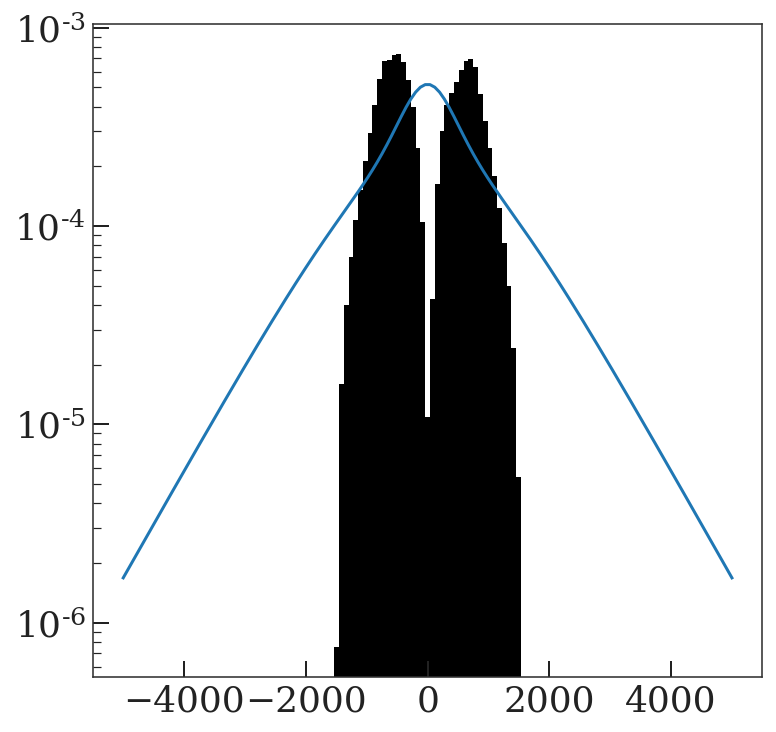

In [18]:
p0 = (
    np.log(gal.shape[0]),
    np.log(250),
    np.log(800),
    0.3,
    -20.8,
    0.,
)
p0_names = (
    'lnn0',
    'lnh1',
    'lnh2',
    'f',
    'zsun',
    'roll'
)
data = gal.cartesian.xyz.decompose(usys).value
like_args = (data, sgrA, ln_density_args, min_b, max_dist)
ln_likelihood(p0, *like_args, plot=True)

In [ ]:
all_vals = np.linspace(0.75, 1.25, 25)[None] * np.array(p0)[:, None]
all_vals[-1] = np.linspace(-0.3, 0.3, all_vals[-1].size) # roll

all_lls = []
for i in range(len(p0)):
    print(i)
    this_p0 = np.array(p0, copy=True)
    lls = []
    vals = all_vals[i]
    for j, val in enumerate(vals):
        print(f"{j}/{len(vals)}", end="\r")
        this_p0[i] = val
        lls.append(ln_likelihood(this_p0, *like_args))
    all_lls.append(lls)
all_lls = np.array(all_lls)

0
14/25
24/25
34/25


In [ ]:
for i in range(all_lls.shape[0]):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].plot(all_vals[i], all_lls[i])
    axes[1].plot(all_vals[i], np.exp(all_lls[i] - all_lls[i].max()))
    for ax in axes:
        ax.set_xlabel(p0_names[i])
        ax.axvline(p0[i])

In [ ]:
full_res = minimize(
    lambda *args: -ln_likelihood(*args), 
    x0=p0, 
    args=like_args, 
    method='nelder-mead'
)